# ROW Algorithm for Continual Learning
This notebook implements the ROW (Replay, OOD, WP) algorithm to handle continual learning tasks. The objective is to train a model that can incrementally learn new tasks while minimizing catastrophic forgetting.


In [1]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_data_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Load CIFAR-100 dataset
train_data_cifar100 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_data_cifar100 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# DataLoaders
train_loader_cifar10 = torch.utils.data.DataLoader(train_data_cifar10, batch_size=64, shuffle=True)
test_loader_cifar10 = torch.utils.data.DataLoader(test_data_cifar10, batch_size=64, shuffle=False)

train_loader_cifar100 = torch.utils.data.DataLoader(train_data_cifar100, batch_size=64, shuffle=True)
test_loader_cifar100 = torch.utils.data.DataLoader(test_data_cifar100, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70980394..1.0].


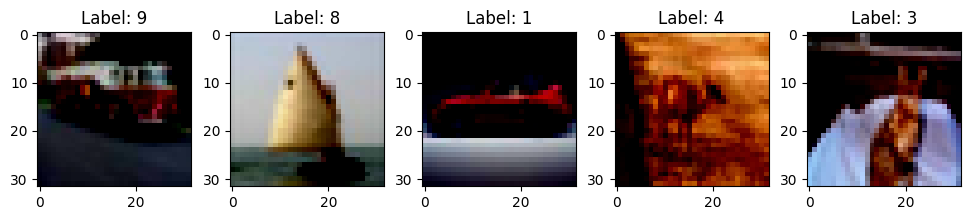

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7176471..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].


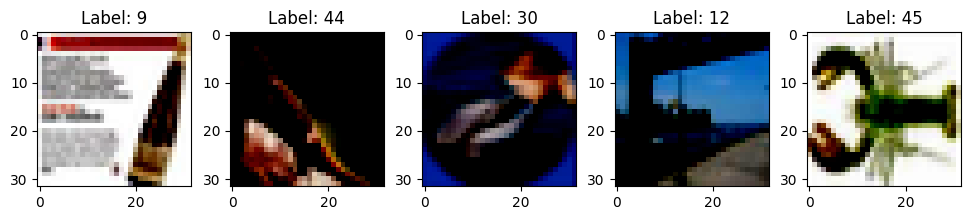

In [3]:
# Display sample images from CIFAR-10
def show_sample_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)  
    fig, ax = plt.subplots(1, 5, figsize=(12, 2))
    for i in range(5):
        ax[i].imshow(np.transpose(images[i], (1, 2, 0)))
        ax[i].set_title(f"Label: {labels[i].item()}")
    plt.show()

# Show CIFAR-10 samples
show_sample_images(train_loader_cifar10)

# Show CIFAR-100 samples
show_sample_images(train_loader_cifar100)


In [4]:
import torch.nn as nn
import torchvision.models as models

# Define Feature Extractor using ResNet18 with new 'weights' argument
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) 
        self.features = nn.Sequential(*list(resnet.children())[:-1])  

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  


In [5]:
# Define OOD and WP heads
class OODHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(OODHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

class WPHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(WPHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [6]:
class ReplayBuffer:
    def __init__(self, capacity=200):
        self.capacity = capacity
        self.buffer = []

    def add(self, data):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0) 
        self.buffer.append(data)

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return None  
        return random.sample(self.buffer, batch_size)


In [7]:
# Define training loop with replay buffer usage
def train_model(feature_extractor, ood_head, wp_head, train_loader, replay_buffer, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(list(feature_extractor.parameters()) + list(ood_head.parameters()) + list(wp_head.parameters()), lr=0.001)
    
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            # Forward pass through feature extractor
            features = feature_extractor(inputs)
            
            # OOD and WP outputs
            ood_outputs = ood_head(features)
            wp_outputs = wp_head(features)
            
            # Compute losses
            loss_ood = criterion(ood_outputs, labels)
            loss_wp = criterion(wp_outputs, labels)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss = loss_ood + loss_wp
            loss.backward()
            optimizer.step()
            
            # Add current batch to replay buffer
            replay_buffer.add((features.detach(), labels.detach()))  
        # Replay training every 2 epochs
        if epoch % 2 == 0:
            replay_data = replay_buffer.sample(32)
            if replay_data is not None:
                replay_features, replay_labels = zip(*replay_data)  
                replay_features = torch.cat(replay_features)
                replay_labels = torch.cat(replay_labels)
                
                # Forward pass on replayed data
                replay_ood_outputs = ood_head(replay_features)
                replay_wp_outputs = wp_head(replay_features)
                
                # Compute replay loss
                loss_replay_ood = criterion(replay_ood_outputs, replay_labels)
                loss_replay_wp = criterion(replay_wp_outputs, replay_labels)
                
                # Optimize using replayed data
                optimizer.zero_grad()
                loss_replay = loss_replay_ood + loss_replay_wp
                loss_replay.backward()
                optimizer.step()
                
                print(f"Training on replay data for epoch {epoch}.")
            else:
                print(f"Not enough data in replay buffer at epoch {epoch}.")
    
    print(f"Training complete for {num_epochs} epochs.")



In [8]:
def evaluate_model(feature_extractor, wp_head, ood_head, test_loader):
    feature_extractor.eval()
    wp_head.eval()
    ood_head.eval()
    
    correct_wp = 0
    total = 0
    correct_ood = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            features = feature_extractor(inputs)
            wp_outputs = wp_head(features)
            ood_outputs = ood_head(features)
            
            _, predicted_wp = torch.max(wp_outputs.data, 1)
            _, predicted_ood = torch.max(ood_outputs.data, 1)
            
            total += labels.size(0)
            correct_wp += (predicted_wp == labels).sum().item()
            correct_ood += (predicted_ood == labels).sum().item()

    wp_accuracy = 100 * correct_wp / total
    ood_accuracy = 100 * correct_ood / total
    print(f"WP Accuracy: {wp_accuracy:.2f}%")
    print(f"OOD Accuracy: {ood_accuracy:.2f}%")


## Experiment 1: Training on CIFAR-10 with ROW Algorithm


In [9]:
# Initialize components
feature_extractor = FeatureExtractor()
ood_head = OODHead(input_dim=512, num_classes=10)
wp_head = WPHead(input_dim=512, num_classes=10)

replay_buffer = ReplayBuffer(capacity=200)

# Train the model
train_model(feature_extractor, ood_head, wp_head, train_loader_cifar10, replay_buffer, num_epochs=10)

# Evaluate on CIFAR-10
evaluate_model(feature_extractor, wp_head, ood_head, test_loader_cifar10)


Training on replay data for epoch 0.
Training on replay data for epoch 2.
Training on replay data for epoch 4.
Training on replay data for epoch 6.
Training on replay data for epoch 8.
Training complete for 10 epochs.
WP Accuracy: 79.39%
OOD Accuracy: 79.51%


In [10]:
# Modify number of classes for CIFAR-100
ood_head = OODHead(input_dim=512, num_classes=100)
wp_head = WPHead(input_dim=512, num_classes=100)

# Train the model on CIFAR-100
train_model(feature_extractor, ood_head, wp_head, train_loader_cifar100, replay_buffer, num_epochs=10)

# Evaluate on CIFAR-100
evaluate_model(feature_extractor, wp_head, ood_head, test_loader_cifar100)


Training on replay data for epoch 0.
Training on replay data for epoch 2.
Training on replay data for epoch 4.
Training on replay data for epoch 6.
Training on replay data for epoch 8.
Training complete for 10 epochs.
WP Accuracy: 46.73%
OOD Accuracy: 46.72%
